# 用于预训练词嵌入的数据集

In [1]:
import math
import os
import torch
import random
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = d2l.download_extract('ptb')
    # Readthetrainingset.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f"vocab size: {len(vocab)}"

'vocab size: 6719'

In [4]:
import collections


def count_corpus(tokens):
    """
    统计语料中各词元的出现频率
    
    参数:
        tokens: 1D(词元列表)或2D(每行为词元列表的列表)
            例如: ['the', 'cat', 'sat'] 或 [['the', 'cat'], ['sat', 'on']]
    返回:
        collections.Counter对象（词元到计数的映射）
            例如: Counter({'the': 2, 'cat': 1, 'sat': 1, 'on': 1})
    
    实现步骤详解:
    1. 判断输入是否为2D列表（每行是一个词元列表）
    2. 如果是2D列表，使用列表推导式展平为1D列表
       列表推导式解析: [token for line in tokens for token in line]
       - 外层循环: for line in tokens (遍历每一行/句子)
       - 内层循环: for token in line (遍历每行中的每个词元)
       - 结果: 将所有词元展平到一个列表中
    3. 使用 collections.Counter 统计每个词元的出现次数
       Counter 会自动统计并返回一个类似字典的对象
    """
    # 步骤1: 判断是否为2D列表（空列表或第一个元素是列表）
    # isinstance(tokens[0], list) 检查第一个元素是否为列表类型
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 步骤2: 展平2D列表为1D列表
        # 示例: [['the', 'cat'], ['sat', 'on']] -> ['the', 'cat', 'sat', 'on']
        tokens = [token for line in tokens for token in line]
    
    # 步骤3: 使用 Counter 统计词元频率
    # Counter 会遍历所有词元，统计每个词元出现的次数
    # 返回结果类似字典: Counter({'the': 2, 'cat': 1, ...})
    return collections.Counter(tokens)

In [5]:
def subsample(sentences, vocab):
    # 步骤1: 过滤掉未知词元 <unk>
    # 只保留在词表中存在的词元（vocab[token] != vocab.unk）
    sentences = [[token for token in line if vocab[token] != vocab.unk] for  line in sentences]
    
    # 步骤2: 统计过滤后每个词元的出现频率
    # count_corpus 会:
    #   - 将2D列表 sentences 展平为1D列表
    #   - 使用 Counter 统计每个词元的出现次数
    # 返回 Counter 对象，例如: Counter({'the': 50770, 'of': 19936, ...})
    counter = count_corpus(sentences)
    
    # 步骤3: 计算总词元数
    # counter.values() 返回所有词元的计数列表，sum() 求和得到总词元数
    num_tokens = sum(counter.values())
    
    # 步骤4: 定义下采样函数
    # 根据词元频率决定是否保留该词元
    # 公式: P(保留) = sqrt(1e-4 / f(w) * num_tokens)
    # 其中 f(w) 是词元 w 的出现频率（通过 counter[token] 获取）
    # 高频词保留概率低，低频词保留概率高
    def keep(token):
        # random.uniform(0, 1) 生成0到1之间的随机数
        # 如果随机数小于计算出的概率，则保留该词元
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    # 步骤5: 对每个句子中的词元应用 keep 函数进行下采样
    # 返回一个元组，包含两个元素:
    #   1. 下采样后的句子列表（2D列表）: [[token, ...], [token, ...], ...]
    #      - 每个内层列表是一个句子，包含经过下采样保留的词元
    #      - 高频词被随机删除的概率更高，低频词保留的概率更高
    #   2. counter (Counter对象): 词元频率统计字典
    #      - 键: 词元（字符串）
    #      - 值: 该词元在过滤<unk>后的语料中出现的总次数
    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

# 最终输出:
# subsampled: 2D列表，下采样后的句子集合，用于训练词嵌入模型
# counter: Counter对象，包含每个词元的频率统计，可用于后续分析
# 注意: 使用 subsampled 而不是 subsample，避免覆盖函数定义
subsampled, counter = subsample(sentences, vocab)

In [6]:
# 查看最终输出的内容和格式
print("=" * 60)
print("最终输出说明")
print("=" * 60)

print(f"\n1. subsampled 变量的类型: {type(subsampled)}")
print(f"   subsampled 是一个2D列表（列表的列表）")
print(f"   - 外层列表: 每个元素代表一个句子")
print(f"   - 内层列表: 每个元素代表该句子中的一个词元")
print(f"\n   前3个句子示例:")
for i, sentence in enumerate(subsampled[:3]):
    print(f"   句子 {i+1}: {sentence}")

print(f"\n2. counter 变量的类型: {type(counter)}")
print(f"   counter 是一个 Counter 对象（类似字典）")
print(f"   - 键(key): 词元（字符串）")
print(f"   - 值(value): 该词元在过滤后的语料中出现的次数")
print(f"\n   最常见的10个词元及其频率:")
for token, freq in counter.most_common(10):
    print(f"   '{token}': {freq}")

print(f"\n3. 统计信息:")
print(f"   - 下采样后的句子总数: {len(subsampled)}")
print(f"   - 下采样后的总词元数: {sum(len(sentence) for sentence in subsampled)}")
print(f"   - 唯一词元数: {len(counter)}")
print(f"   - 总词元数（counter统计）: {sum(counter.values())}")

print(f"\n4. 使用示例:")
print(f"   - 访问第1个句子: subsampled[0] = {subsampled[0]}")
print(f"   - 查询词元频率: counter['the'] = {counter.get('the', 0)}")
print(f"   - 获取所有词元: list(counter.keys())[:5] = {list(counter.keys())[:5]}")

最终输出说明

1. subsampled 变量的类型: <class 'list'>
   subsampled 是一个2D列表（列表的列表）
   - 外层列表: 每个元素代表一个句子
   - 内层列表: 每个元素代表该句子中的一个词元

   前3个句子示例:
   句子 1: []
   句子 2: ['old', 'join', 'the', 'as', 'director', 'nov.']
   句子 3: ['n.v.', 'dutch', 'publishing', 'group']

2. counter 变量的类型: <class 'collections.Counter'>
   counter 是一个 Counter 对象（类似字典）
   - 键(key): 词元（字符串）
   - 值(value): 该词元在过滤后的语料中出现的次数

   最常见的10个词元及其频率:
   'the': 50770
   'N': 32481
   'of': 24400
   'to': 23638
   'a': 21196
   'in': 18000
   'and': 17474
   ''s': 9784
   'that': 8931
   'for': 8927

3. 统计信息:
   - 下采样后的句子总数: 42069
   - 下采样后的总词元数: 344263
   - 唯一词元数: 6718
   - 总词元数（counter统计）: 820056

4. 使用示例:
   - 访问第1个句子: subsampled[0] = []
   - 查询词元频率: counter['the'] = 50770
   - 获取所有词元: list(counter.keys())[:5] = ['N', 'years', 'old', 'will', 'join']


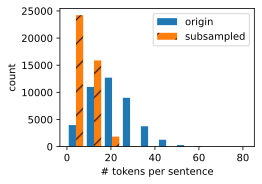

In [7]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled);

In [8]:
def compare_counts(token):
    return (f"{token} 数量："
             f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'the 数量：之前=50770, 之后=2078'

In [9]:
compare_counts('join')

'join 数量：之前=45, 之后=45'

In [10]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [4127, 3228, 6079, 416, 1773, 4060], [3922, 1922, 4743, 2696]]

In [11]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """
    返回跳元模型(Skip-gram)中的中心词和上下文词
    
    ============================================================
    Skip-gram模型的核心思想
    ============================================================
    
    给定一个中心词，预测其周围的上下文词
    例如: "the cat sat on the mat"
    - 中心词: "sat"
    - 上下文词(窗口=2): ["cat", "on"] 或 ["the", "cat", "on", "the"]
    
    ============================================================
    关键点: 窗口大小是随机的！
    ============================================================
    
    为什么要随机窗口大小?
    1. 距离越近的词，语义关联通常越强
    2. 随机窗口使得近距离词有更高的采样概率
    
    举例说明 (max_window_size=5):
    - 窗口=1时: 只采样距离1的词
    - 窗口=2时: 采样距离1和2的词
    - 窗口=5时: 采样距离1到5的词
    
    距离为1的词: 每次都会被采样(窗口1-5都包含)
    距离为5的词: 只有窗口=5时才被采样(1/5的概率)
    
    这相当于对近距离词给予更高的权重!
    
    参数:
        corpus: 2D列表，每个元素是一个句子的词索引列表
            例如: [[12, 45, 67], [23, 89, 12, 34], ...]
        max_window_size: 最大窗口大小
            例如: 5 表示窗口大小在1-5之间随机
    
    返回:
        centers: 所有中心词的列表 (1D)
        contexts: 每个中心词对应的上下文词列表 (2D)
    """
    centers, contexts = [], []
    
    for line in corpus:
        # 句子至少需要2个词才能形成"中心词-上下文词"对
        if len(line) < 2:
            continue
        
        # 每个词都作为中心词
        centers += line
        
        for i in range(len(line)):  # i 是中心词的位置
            # 关键! 窗口大小是随机的，范围[1, max_window_size]
            # 这使得近距离词被采样的概率更高
            window_size = random.randint(1, max_window_size)
            
            # 计算上下文词的索引范围
            # max(0, i - window_size): 左边界，不能小于0
            # min(len(line), i + 1 + window_size): 右边界，不能超过句子长度
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            
            # 从上下文中排除中心词自己
            indices.remove(i)
            
            # 获取上下文词
            contexts.append([line[idx] for idx in indices])
    
    return centers, contexts

# 图解示例:
# 句子: [0, 1, 2, 3, 4, 5, 6]
# max_window_size = 2
#
# 中心词=2, 随机window_size=2:
#   indices = [0, 1, 2, 3, 4] -> 移除2 -> [0, 1, 3, 4]
#   上下文词: [0, 1, 3, 4] (前后各2个)
#
# 中心词=2, 随机window_size=1:
#   indices = [1, 2, 3] -> 移除2 -> [1, 3]
#   上下文词: [1, 3] (前后各1个)
#
# 边界情况:
# 中心词=0, window_size=2:
#   indices = [0, 1, 2] -> 移除0 -> [1, 2]
#   上下文词: [1, 2] (只有右边)

In [12]:
# 用小数据集演示中心词和上下文词的生成
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集:', tiny_dataset)
print('  句子1: [0, 1, 2, 3, 4, 5, 6]')
print('  句子2: [7, 8, 9]')
print()
print('max_window_size=2, 窗口大小随机在[1,2]之间:')
print('-' * 50)

for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    # 根据上下文长度推断窗口大小
    print(f'中心词 {center} 的上下文词是 {context}')

print()
print('注意观察:')
print('- 上下文词数量不固定(因为窗口大小随机)')
print('- 边界词(如0, 6)的上下文较少(一侧没有词)')
print('- 每次运行结果可能不同(随机性)')

数据集: [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
  句子1: [0, 1, 2, 3, 4, 5, 6]
  句子2: [7, 8, 9]

max_window_size=2, 窗口大小随机在[1,2]之间:
--------------------------------------------------
中心词 0 的上下文词是 [1]
中心词 1 的上下文词是 [0, 2]
中心词 2 的上下文词是 [1, 3]
中心词 3 的上下文词是 [1, 2, 4, 5]
中心词 4 的上下文词是 [3, 5]
中心词 5 的上下文词是 [4, 6]
中心词 6 的上下文词是 [4, 5]
中心词 7 的上下文词是 [8, 9]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [8]

注意观察:
- 上下文词数量不固定(因为窗口大小随机)
- 边界词(如0, 6)的上下文较少(一侧没有词)
- 每次运行结果可能不同(随机性)


In [13]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中心词-上下文词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

'# “中心词-上下文词对”的数量: 1506172'

In [14]:
#@save
class RandomGenerator:
    """
    高效的带权重随机采样器 - 用于负采样(Negative Sampling)
    
    ============================================================
    为什么需要负采样? (Word2Vec的核心优化技术)
    ============================================================
    
    原始Skip-gram模型的问题:
    - 需要计算softmax: P(context|center) = exp(v_context · v_center) / Σexp(v_i · v_center)
    - 分母需要遍历整个词表(可能有几十万个词)，计算量巨大
    - 每次更新一个词对，需要更新所有词的梯度
    
    负采样的解决方案:
    - 不再计算完整的softmax
    - 只区分"真正的上下文词"和"随机采样的噪声词"
    - 将多分类问题转化为多个二分类问题
    - 每次只更新少量词的嵌入向量(正样本 + K个负样本)
    
    训练目标变为:
    - 最大化: P(D=1|center, true_context)     # 真正的上下文词，标签为1
    - 最小化: P(D=1|center, negative_sample)  # 噪声词，标签为0
    
    ============================================================
    这个类的作用: 高效地按权重随机抽取噪声词
    ============================================================
    
    为什么要缓存10000个样本?
    - random.choices() 每次调用都有开销
    - 如果每次只抽1个，调用100万次 = 100万次函数调用开销
    - 批量抽取10000个，只需调用100次，效率提升100倍!
    
    采样权重的设计:
    - 使用 freq^0.75 而不是原始频率
    - 0.75次幂会"压缩"高频词的权重，给低频词更多机会
    - 原因: 如果完全按频率采样，"the"、"a"这些词会被过度采样
    """
    def __init__(self, sampling_weights):
        """
        初始化随机生成器
        
        参数:
            sampling_weights: 采样权重列表，长度为n
                例如: [2, 3, 4] 表示3个词，采样概率比为 2:3:4
        
        属性说明:
            population: 候选词的索引列表 [1, 2, ..., n]
                注意从1开始，因为索引0是<unk>，我们不采样未知词
            sampling_weights: 每个词的采样权重
            candidates: 预生成的随机样本缓存列表
            i: 当前读取位置的指针
        """
        # 候选词索引: [1, 2, 3, ..., n]
        # 从1开始是因为词表索引0是<unk>标记，排除它
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []  # 缓存的随机样本
        self.i = 0            # 当前读取位置

    def draw(self):
        """
        抽取一个随机样本(噪声词的索引)
        
        工作流程:
        1. 检查缓存是否用完 (self.i == len(self.candidates))
        2. 如果用完，批量生成10000个新样本
        3. 返回下一个样本，指针后移
        
        返回:
            int: 随机抽取的词索引 (1到n之间)
        
        示例:
            假设 population=[1,2,3], weights=[2,3,4]
            - 词1的采样概率 = 2/(2+3+4) ≈ 22%
            - 词2的采样概率 = 3/(2+3+4) ≈ 33%
            - 词3的采样概率 = 4/(2+3+4) ≈ 44%
        """
        if self.i == len(self.candidates):
            # 缓存用完了，批量生成k=10000个随机采样结果
            # random.choices: 带权重的随机采样，可重复抽取
            # population: 候选值列表
            # weights: 对应的权重
            # k: 抽取数量
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0  # 重置指针
        self.i += 1
        return self.candidates[self.i - 1]

## 负采样 (Negative Sampling) - Word2Vec的核心优化技术

### 为什么需要负采样?

原始Skip-gram的计算瓶颈:
```
P(context|center) = softmax = exp(v_context · v_center) / Σ_all_words exp(v_i · v_center)
```
- 分母需要遍历整个词表(几十万词)
- 每次更新都需要计算所有词的梯度

### 负采样的核心思想

将**多分类问题**转化为**多个二分类问题**:
- 正样本: (center, true_context) → label=1 "确实共现"
- 负样本: (center, random_noise) → label=0 "随机配对"

### 训练目标

最大化: `log σ(v_context · v_center) + Σ_k log σ(-v_noise_k · v_center)`

- 第一项: 让真实上下文词与中心词的向量点积变大
- 第二项: 让噪声词与中心词的向量点积变小

### 10000缓存的意义

`RandomGenerator`中的`k=10000`是**性能优化**:
- 批量生成10000个随机数，存入缓存
- 需要时从缓存取，用完再批量生成
- 避免频繁调用`random.choices()`的开销

In [15]:
# 测试RandomGenerator: 验证带权重的随机采样
# 权重 [2, 3, 4] 对应索引 [1, 2, 3]
# 理论概率: P(1)=2/9≈22%, P(2)=3/9≈33%, P(3)=4/9≈44%
generator = RandomGenerator([2, 3, 4])
samples = [generator.draw() for _ in range(10)]
print(f"10次采样结果: {samples}")
print("预期: 3出现最多(权重4), 1出现最少(权重2)")

# 大量采样验证概率分布
from collections import Counter
large_sample = [generator.draw() for _ in range(10000)]
counts = Counter(large_sample)
print(f"\n10000次采样统计:")
for idx in [1, 2, 3]:
    freq = counts[idx] / 10000 * 100
    expected = [2, 3, 4][idx-1] / 9 * 100
    print(f"  索引{idx}: 实际{freq:.1f}%, 理论{expected:.1f}%")

10次采样结果: [1, 3, 2, 3, 3, 3, 3, 3, 3, 2]
预期: 3出现最多(权重4), 1出现最少(权重2)

10000次采样统计:
  索引1: 实际22.3%, 理论22.2%
  索引2: 实际33.1%, 理论33.3%
  索引3: 实际44.6%, 理论44.4%


In [16]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """
    为每个中心词-上下文词对生成K个负样本(噪声词)
    
    ============================================================
    负采样在Word2Vec训练中的角色
    ============================================================
    
    训练数据结构:
    - 正样本: (center, context) -> label=1  "这两个词确实共同出现"
    - 负样本: (center, noise)   -> label=0  "这两个词是随机配对的"
    
    为什么需要负样本?
    - 如果只有正样本，模型会学到"所有词对都相似"
    - 负样本告诉模型"哪些词不应该相似"
    - 通过对比学习，模型学会区分真实共现和随机配对
    
    K的含义:
    - 每个正样本配K个负样本
    - 例如 K=5: 1个真实上下文词 + 5个噪声词
    - K越大，训练越稳定，但计算量也越大
    - 论文推荐: 小数据集K=5-20, 大数据集K=2-5
    
    ============================================================
    采样权重设计: freq^0.75 (经典论文公式)
    ============================================================
    
    为什么用 0.75 次幂?
    - 原始频率采样: P(w) = freq(w) / total
      问题: "the"出现5万次，"python"出现100次
            "the"被采样的概率是"python"的500倍，太极端了
    
    - 0.75次幂平滑: P(w) = freq(w)^0.75 / Σ freq(i)^0.75
      效果: 50000^0.75 ≈ 3344, 100^0.75 ≈ 31.6
            比值从500:1降到约106:1，更均衡
    
    - 这是Mikolov原论文中的经验值，实验效果最好
    
    参数:
        all_contexts: 所有中心词对应的上下文词列表
            例如: [[2,3], [1,3,4], [2,4], ...]
            每个元素是一个中心词的所有上下文词索引
        vocab: 词表对象
        counter: 词频统计 Counter对象
        K: 每个上下文词对应的负样本数量
    
    返回:
        all_negatives: 与all_contexts对应的负样本列表
            例如: [[5,6,7,8,9,10], [1,5,6,7,8,9,10,11,12], ...]
            每个中心词的负样本数 = len(contexts) * K
    """
    # 步骤1: 计算采样权重
    # 索引从1开始，因为索引0是<unk>标记，不参与采样
    # vocab.to_tokens(i): 将索引i转换为词元字符串
    # counter[token]: 获取该词的出现次数
    # **0.75: 应用0.75次幂平滑
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    
    # 步骤2: 初始化
    all_negatives = []  # 存储所有负样本
    generator = RandomGenerator(sampling_weights)  # 创建带权重的随机采样器
    
    # 步骤3: 为每个中心词生成负样本
    for contexts in all_contexts:
        negatives = []
        # 每个上下文词配K个负样本
        # 例如: contexts有3个词，K=5，则需要生成15个负样本
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()  # 随机抽取一个噪声词索引
            # 关键: 噪声词不能是真正的上下文词!
            # 否则会产生矛盾的训练信号(同一个词对既是正样本又是负样本)
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    
    return all_negatives

# 生成负样本，K=5表示每个正样本配5个负样本
all_negatives = get_negatives(all_contexts, vocab, counter, 5)

# 查看负采样结果示例
print("=" * 60)
print("负采样结果示例")
print("=" * 60)
print(f"\n第一个中心词的上下文词数量: {len(all_contexts[0])}")
print(f"第一个中心词的负样本数量: {len(all_negatives[0])} (= {len(all_contexts[0])} × 5)")
print(f"\n上下文词索引: {all_contexts[0]}")
print(f"负样本索引: {all_negatives[0]}")

负采样结果示例

第一个中心词的上下文词数量: 3
第一个中心词的负样本数量: 15 (= 3 × 5)

上下文词索引: [3228, 6079, 416]
负样本索引: [3128, 6241, 4647, 2185, 3333, 1482, 4530, 602, 3316, 2988, 6267, 5991, 659, 6598, 4194]


In [17]:
#@save
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [18]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [19]:
# 将PTBDataset类移到函数外部
class PTBDataset(torch.utils.data.Dataset):
    """PTB数据集类，用于Word2Vec训练"""
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)


#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    # 在Jupyter notebook中使用num_workers=0避免多进程pickle问题
    # 多进程在notebook中无法正确序列化主模块中定义的类
    num_workers = 0
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

In [20]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])
